### simplest autoencoder  
We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

_[1]encodingdim=32=>CODE的維度_  
_[2]Dense=>全連接層_  
_[3]activation=relu,不同的activation分別有什麼作用_(http://mropengate.blogspot.tw/2017/02/deep-learning-role-of-activation.html)

In [212]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 16  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

In [213]:
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# Let's also create a separate encoder model:

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [214]:
# As well as the decoder model:

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

_[5]adadelta?binarycrossentropy?_  
_adadelta[公式](http://ruder.io/optimizing-gradient-descent/index.html#adadelta) [如何選擇optimizer](https://www.jianshu.com/p/d99b83f4c1a6)_  
_binarycrossentropy_

In [215]:
# Now let's train our autoencoder to reconstruct MNIST digits.
# First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Let's prepare our input data. We're using MNIST digits, and we're **discarding the labels** (since we're only interested in encoding/decoding the input images).

In [216]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()# 若不加底線(x_train, y_train)則會取得label

We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [217]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Now let's train our autoencoder for **50 epochs**:

_[6]batchsize調大會更快_  
_[7]shuffle? [for-keras-fit-method-does-shuffle-true-shuffle-both-the-training-and-validation-samples-or-just-the-training-dataset](http://forums.fast.ai/t/for-keras-fit-method-does-shuffle-true-shuffle-both-the-training-and-validation-samples-or-just-the-training-dataset/2992/2)_

In [218]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.3663 - val_loss: 0.2726
Epoch 2/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.2667 - val_loss: 0.2576
Epoch 3/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.2489 - val_loss: 0.2378
Epoch 4/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.2299 - val_loss: 0.2198
Epoch 5/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.2150 - val_loss: 0.2079
Epoch 6/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.2049 - val_loss: 0.1990
Epoch 7/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.1968 - val_loss: 0.1915
Epoch 8/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.1898 - val_loss: 0.1853
Epoch 9/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.1842 - val_loss: 0.1803
Epoch

After 50 epochs, the autoencoder seems to reach a stable train/test loss value of about **0.11**. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

_[8]predict?_

In [219]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

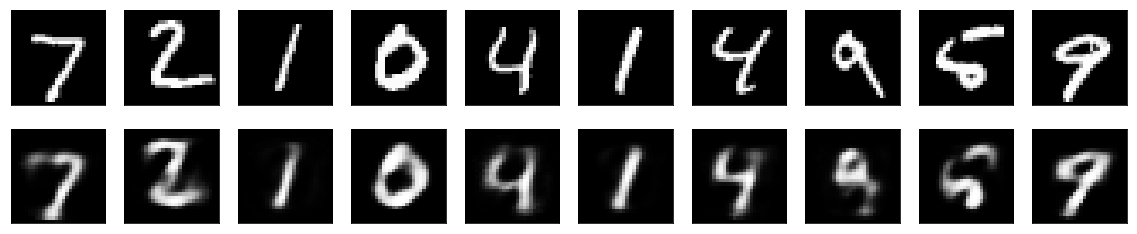

In [220]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

------

### adding a sparsity constraint on the encoded representations ###

In the previous example, the representations were only constrained by the size of the **hidden layer (32)**. In such a situation, what typically happens is that the hidden layer is learning an approximation of **PCA (principal component analysis)**. But another way to constrain the representations to be compact is to add a **sparsity contraint** on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an **activity_regularizer** to our Dense layer:

#### 要修改regularizer的值!!不然會跑出全部都一樣的模糊結果 原本他給的值不夠大 10e5=10乘10的五次方 ####

In [65]:
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer

#revised!!!!
#encoded = Dense(encoding_dim, activation='relu',
#                activity_regularizer=regularizers.l1(10e-5))(input_img)
    
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-7))(input_img)
    
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

In [66]:
# Let's also create a separate encoder model:

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [67]:
# As well as the decoder model:

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [68]:
# Now let's train our autoencoder to reconstruct MNIST digits.
# First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Let's train this model for **100 epochs** (with the added regularization the model is less likely to **overfit** and can be trained longer). The models ends with a train loss of 0.11 and test loss of 0.10. The difference between the two is mostly due to the regularization term being added to the loss during training (worth about 0.01).

#### 算出來的結果會與官網不同 ####

In [69]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 6s 98us/step - loss: 0.3830 - val_loss: 0.2906
Epoch 2/100
60000/60000 [==============================] - 3s 50us/step - loss: 0.2844 - val_loss: 0.2761
Epoch 3/100
60000/60000 [==============================] - 3s 47us/step - loss: 0.2673 - val_loss: 0.2566
Epoch 4/100
60000/60000 [==============================] - 3s 47us/step - loss: 0.2497 - val_loss: 0.2408
Epoch 5/100
60000/60000 [==============================] - 3s 46us/step - loss: 0.2352 - val_loss: 0.2274
Epoch 6/100
60000/60000 [==============================] - 3s 48us/step - loss: 0.2233 - val_loss: 0.2171
Epoch 7/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.2144 - val_loss: 0.2094
Epoch 8/100
60000/60000 [==============================] - 3s 49us/step - loss: 0.2077 - val_loss: 0.2034
Epoch 9/100
60000/60000 [==============================] - 3s 47us/step - loss: 0.2022 - val_loss: 0.1

60000/60000 [==============================] - 4s 61us/step - loss: 0.1404 - val_loss: 0.1386
Epoch 78/100
60000/60000 [==============================] - 4s 59us/step - loss: 0.1403 - val_loss: 0.1385
Epoch 79/100
60000/60000 [==============================] - 3s 57us/step - loss: 0.1402 - val_loss: 0.1384
Epoch 80/100
60000/60000 [==============================] - 3s 51us/step - loss: 0.1400 - val_loss: 0.1383
Epoch 81/100
60000/60000 [==============================] - 3s 55us/step - loss: 0.1399 - val_loss: 0.1381
Epoch 82/100
60000/60000 [==============================] - 3s 47us/step - loss: 0.1398 - val_loss: 0.1380
Epoch 83/100
60000/60000 [==============================] - 3s 48us/step - loss: 0.1397 - val_loss: 0.1379
Epoch 84/100
60000/60000 [==============================] - 3s 47us/step - loss: 0.1396 - val_loss: 0.1378
Epoch 85/100
60000/60000 [==============================] - 3s 49us/step - loss: 0.1394 - val_loss: 0.1377
Epoch 86/100
60000/60000 [========================

In [70]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

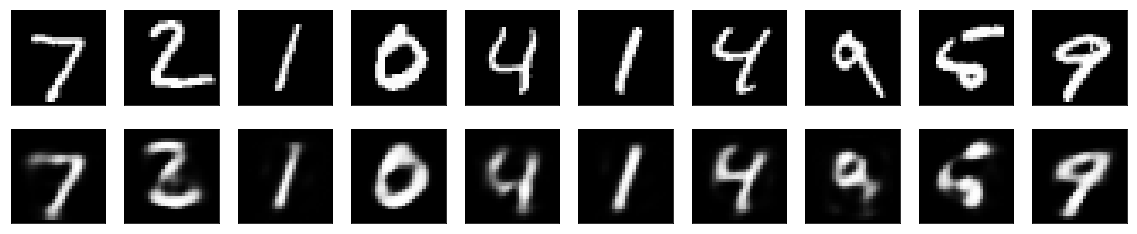

In [71]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

本來的圖片XD
![title](loser.png)  
...............................

They look pretty similar to the previous model, the only significant difference being the sparsity of the encoded representations. encoded_imgs.mean() yields a value 3.33 (over our 10,000 test images), whereas with the previous model the same quantity was 7.30. So our new model yields encoded representations that are twice sparser.

----------------------------------------

### Deep autoencoder ###

We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers, such as:

In [72]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [73]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 5s 81us/step - loss: 0.3451 - val_loss: 0.2631
Epoch 2/100
60000/60000 [==============================] - 4s 74us/step - loss: 0.2538 - val_loss: 0.2432
Epoch 3/100
60000/60000 [==============================] - 5s 77us/step - loss: 0.2332 - val_loss: 0.2207
Epoch 4/100
60000/60000 [==============================] - 4s 63us/step - loss: 0.2126 - val_loss: 0.2061
Epoch 5/100
60000/60000 [==============================] - 4s 62us/step - loss: 0.1994 - val_loss: 0.1940
Epoch 6/100
60000/60000 [==============================] - 4s 60us/step - loss: 0.1898 - val_loss: 0.1834
Epoch 7/100
60000/60000 [==============================] - 4s 60us/step - loss: 0.1811 - val_loss: 0.1763
Epoch 8/100
60000/60000 [==============================] - 4s 61us/step - loss: 0.1751 - val_loss: 0.1710
Epoch 9/100
60000/60000 [==============================] - 4s 63us/step - loss: 0.1695 - val_loss: 0.1

60000/60000 [==============================] - 4s 68us/step - loss: 0.1043 - val_loss: 0.1033
Epoch 78/100
60000/60000 [==============================] - 4s 60us/step - loss: 0.1042 - val_loss: 0.1028
Epoch 79/100
60000/60000 [==============================] - 4s 62us/step - loss: 0.1039 - val_loss: 0.1010
Epoch 80/100
60000/60000 [==============================] - 4s 65us/step - loss: 0.1038 - val_loss: 0.1011
Epoch 81/100
60000/60000 [==============================] - 4s 74us/step - loss: 0.1034 - val_loss: 0.1021
Epoch 82/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.1032 - val_loss: 0.1025
Epoch 83/100
60000/60000 [==============================] - 4s 71us/step - loss: 0.1031 - val_loss: 0.1011
Epoch 84/100
60000/60000 [==============================] - 5s 75us/step - loss: 0.1029 - val_loss: 0.1012
Epoch 85/100
60000/60000 [==============================] - 4s 73us/step - loss: 0.1026 - val_loss: 0.1030
Epoch 86/100
60000/60000 [========================

After 100 epochs, it reaches a train and test loss of ~0.097, a bit better than our previous models. Our reconstructed digits look a bit better too:

In [74]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

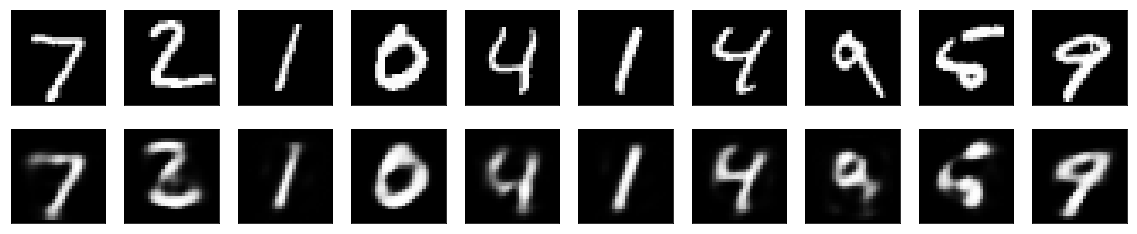

In [75]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

-------------

### Convolutional autoencoder ###

Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [76]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)# 加stride
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

To train it, we will use the original MNIST digits with shape (samples, 3, 28, 28), and we will just normalize pixel values between 0 and 1.

In [77]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

Let's train this model for 50 epochs. For the sake of demonstrating how to visualize the results of a model during training, we will be using the TensorFlow backend and the TensorBoard callback.

First, let's open up a terminal and start a TensorBoard server that will read logs stored at /tmp/autoencoder.  
``` 
tensorboard --logdir=/tmp/autoencoder
```  
Then let's train our model. In the callbacks list we pass an instance of the TensorBoard callback. After every epoch, this callback will write logs to /tmp/autoencoder, which can be read by our TensorBoard server.

如圖，照著打
![title](tensorboard.png)  
因此在瀏覽器內輸入:http://DESKTOP-HTG7I64:6006 可以觀察  

_以下要跑一陣子_

In [78]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 103s 2ms/step - loss: 0.2123 - val_loss: 0.1614
Epoch 2/50
60000/60000 [==============================] - 81s 1ms/step - loss: 0.1510 - val_loss: 0.1386
Epoch 3/50
60000/60000 [==============================] - 79s 1ms/step - loss: 0.1360 - val_loss: 0.1278
Epoch 4/50
60000/60000 [==============================] - 79s 1ms/step - loss: 0.1287 - val_loss: 0.1224
Epoch 5/50
60000/60000 [==============================] - 86s 1ms/step - loss: 0.1239 - val_loss: 0.1233
Epoch 6/50
60000/60000 [==============================] - 86s 1ms/step - loss: 0.1205 - val_loss: 0.1158
Epoch 7/50
60000/60000 [==============================] - 86s 1ms/step - loss: 0.1177 - val_loss: 0.1122
Epoch 8/50
60000/60000 [==============================] - 86s 1ms/step - loss: 0.1159 - val_loss: 0.1183
Epoch 9/50
60000/60000 [==============================] - 86s 1ms/step - loss: 0.1141 - val_loss: 0.1132
Epoc

![title](graph1.png)

The model converges to a loss of 0.094, significantly better than our previous models (this is in large part due to the higher entropic capacity of the encoded representation, 128 dimensions vs. 32 previously). Let's take a look at the reconstructed digits:

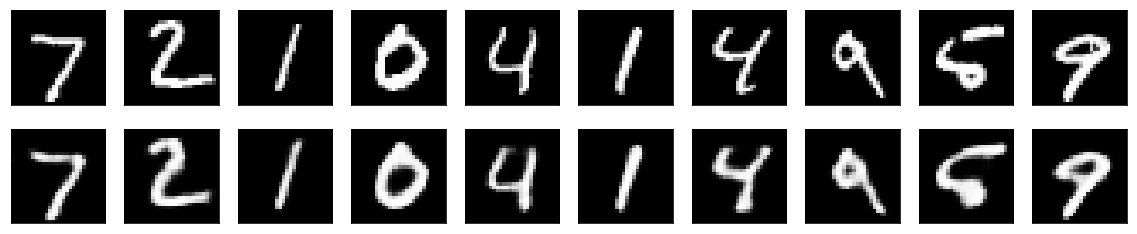

In [82]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 +n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We can also have a look at the 128-dimensional encoded representations. These representations are 8x4x4, so we reshape them to 4x32 in order to be able to display them as grayscale images.

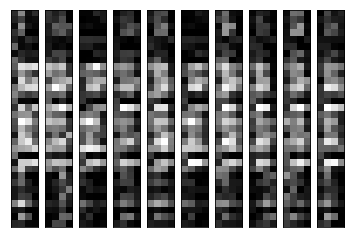

In [92]:
encoder = Model(input_img, encoded)#我自己加的
encoded_imgs = encoder.predict(x_test) #我自己加的

n = 10
#plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)#要加1 i->i+1
    plt.imshow(encoded_imgs[i].reshape(4, 4*8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [93]:
whos

Variable        Type           Data/Info
----------------------------------------
Conv2D          type           <class 'keras.layers.convolutional.Conv2D'>
Dense           type           <class 'keras.layers.core.Dense'>
Input           function       <function Input at 0x000001825322E6A8>
K               module         <module 'keras.backend' f<...>s\\backend\\__init__.py'>
MaxPooling2D    type           <class 'keras.layers.pooling.MaxPooling2D'>
Model           type           <class 'keras.engine.training.Model'>
TensorBoard     type           <class 'keras.callbacks.TensorBoard'>
UpSampling2D    type           <class 'keras.layers.convolutional.UpSampling2D'>
autoencoder     Model          <keras.engine.training.Mo<...>ct at 0x0000018201BD62B0>
ax              AxesSubplot    Axes(0.835703,0.125;0.0629167x0.755)
decoded         Tensor         Tensor("conv2d_7/Sigmoid:<...>8, 28, 1), dtype=float32)
decoded_imgs    ndarray        10000x28x28x1: 7840000 elems, type `float32`, 31360000

_[14]看這個要幹嘛? 所以這個encoded images為什麼是三維的(8x4x4)??_

--------------------------------------------

### Application to image denoising ###

Let's put our convolutional autoencoder to work on an image denoising problem. It's simple: we will train the autoencoder to map noisy digits images to clean digits images.

Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [94]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Here's what the noisy digits look like:

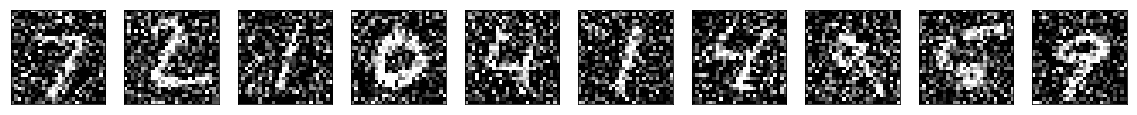

In [95]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)#i==>i+1
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

If you squint you can still recognize them, but barely. Can our autoencoder learn to recover the original digits? Let's find out.

Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slightly different model with more filters per layer:

_[15]改了什麼??_

In [96]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Let's train it for 100 epochs:

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 +n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

因為要跑很久所以直接放跑出來的結果  
![title](denoising_train1.png)  
![title](denoising_train2.png)  
![title](denoising_img.png)  

It seems to work pretty well. If you scale this process to a bigger convnet, you can start building document denoising or audio denoising models. Kaggle has an interesting dataset to get you started.
(https://www.kaggle.com/c/denoising-dirty-documents/data)

----------------------

### Sequence-to-sequence autoencoder ###

If you inputs are sequences, rather than vectors or 2D images, then you may want to use as encoder and decoder a type of model that can capture temporal structure, such as a LSTM. To build a LSTM-based autoencoder, first use a LSTM encoder to turn your input sequences into a single vector that contains information about the entire sequence, then repeat this vector n times (where n is the number of timesteps in the output sequence), and run a LSTM decoder to turn this constant sequence into the target sequence.

We won't be demonstrating that one on any specific dataset. We will just put a code example here for future reference for the reader!

In [127]:
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model

timesteps=10# test

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(latent_dim)(inputs)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

------------

### Variational autoencoder (VAE) ###

What is a variational autoencoder? It's a type of autoencoder with added constraints on the encoded representations being learned.  
More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: **a VAE is a "generative model".**  
  
First, an encoder network turns the input samples x into **two parameters** in a latent space, which we will note **z_mean** and **z_log_sigma**. Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the model are trained via **two loss functions**: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the **KL divergence between the learned latent distribution and the prior distribution**, acting as a **regularization term**. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

In [221]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

In [222]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

First, here's our encoder network, mapping inputs to our latent distribution parameters:

In [223]:
# x = Input(batch_shape=(batch_size, original_dim))
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
#z_log_sigma = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

We can use these parameters to sample new similar points from the latent space:

In [224]:
def sampling(args):
    z_mean, z_log_sigma = args
    # epsilon = K.random_normal(shape=(batch_size, latent_dim),
    #                          mean=0., stddev=epsilon_std)#std ----> stddev
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma / 2) * epsilon    
    # return z_mean + K.exp(z_log_sigma) * epsilon
    
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

Finally, we can map these sampled latent points back to reconstructed inputs:

In [225]:
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

What we've done so far allows us to instantiate 3 models:

* an end-to-end autoencoder mapping inputs to reconstructions
* an encoder mapping inputs to the latent space
* a generator that can take points on the latent space and will output the corresponding reconstructed samples.

In [226]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))

We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

In [227]:
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [229]:
def vae_loss(x, x_decoded_mean):
    xent_loss = tflearn.objectives.binary_crossentropy(x, x_decoded_mean)# install tflearn然後objectives.binary_crossentropy>tflearn.objectives.binary_crossentropy
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [203]:
# vae.compile(optimizer='rmsprop', loss='binary_crossentropy')

We train our VAE on MNIST digits:

In [230]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50


InvalidArgumentError: You must feed a value for placeholder tensor 'input_42' with dtype float and shape [100,784]
	 [[Node: input_42 = Placeholder[dtype=DT_FLOAT, shape=[100,784], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'input_42', defined at:
  File "C:\Users\peipeiju\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\peipeiju\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-181-18d511beb751>", line 1, in <module>
    x = Input(batch_shape=(batch_size, original_dim))
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\keras-2.1.3-py3.6.egg\keras\engine\topology.py", line 1455, in Input
    input_tensor=tensor)
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\keras-2.1.3-py3.6.egg\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\keras-2.1.3-py3.6.egg\keras\engine\topology.py", line 1364, in __init__
    name=self.name)
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\keras-2.1.3-py3.6.egg\keras\backend\tensorflow_backend.py", line 504, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1599, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 3090, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\Users\peipeiju\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_42' with dtype float and shape [100,784]
	 [[Node: input_42 = Placeholder[dtype=DT_FLOAT, shape=[100,784], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [205]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

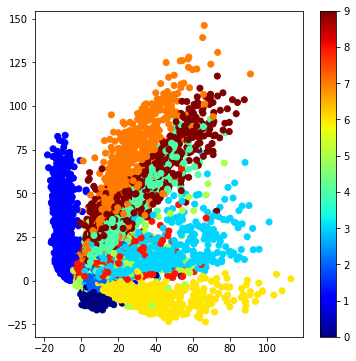

In [206]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test,cmap='jet')
plt.colorbar()
plt.show()

In [207]:
whos

Variable               Type           Data/Info
-----------------------------------------------
Conv2D                 type           <class 'keras.layers.convolutional.Conv2D'>
Dense                  type           <class 'keras.layers.core.Dense'>
Input                  function       <function Input at 0x000001825322E6A8>
K                      module         <module 'keras.backend' f<...>s\\backend\\__init__.py'>
LSTM                   type           <class 'keras.layers.recurrent.LSTM'>
Lambda                 type           <class 'keras.layers.core.Lambda'>
MaxPooling2D           type           <class 'keras.layers.pooling.MaxPooling2D'>
Model                  type           <class 'keras.engine.training.Model'>
RepeatVector           type           <class 'keras.layers.core.RepeatVector'>
TensorBoard            type           <class 'keras.callbacks.TensorBoard'>
UpSampling2D           type           <class 'keras.layers.convolutional.UpSampling2D'>
autoencoder            Model 

Each of these colored clusters is a type of digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space).

Because the VAE is a generative model, we can also use it to generate new digits! Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.

In [208]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

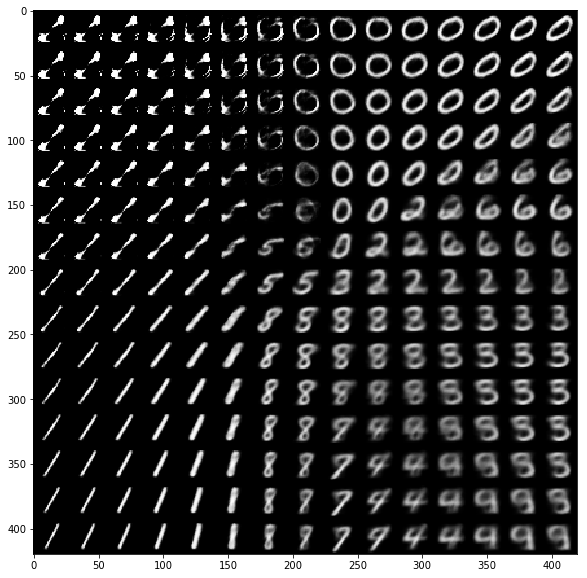

In [209]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

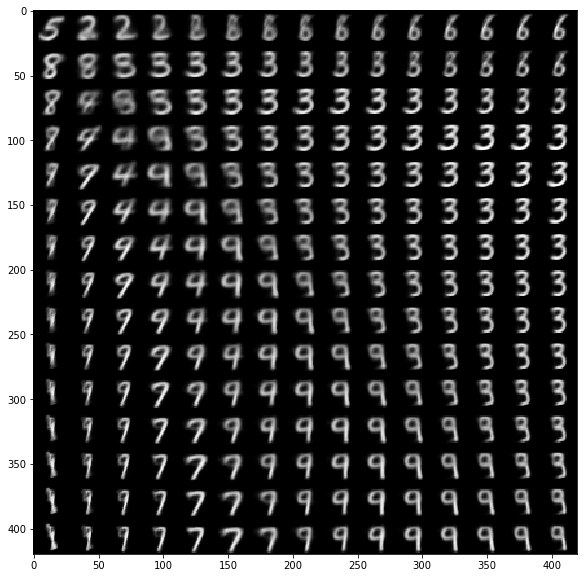

In [211]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(0, 60, n)
grid_y = np.linspace(0, 60, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()